# Part 1

## Imports & Data Preparation

In [1]:
import pandas as pd 
import numpy as np 
import re 
import seaborn as sns
import matplotlib.pyplot as plt 
from datetime import datetime
import ast

# Color codes : 
#95a3c3
#e99675
#72b6a1

In [2]:
#Import data
folder = "generated/"
df_movies=pd.read_csv(folder + "USE_THIS_DATASET.csv", index_col = 'Wikipedia movie ID')

#Add a column that has the decades
df_movies['decade'] = (df_movies['Movie release year'] // 10) * 10

#Add a column that has the seasons
def month_to_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Fall"
df_movies['season'] = df_movies['Movie release month'].apply(month_to_season)

#Add a column that has the release days
df_movies['Movie release date'] = pd.to_datetime(df_movies['Movie release date'], errors='coerce')
df_movies['Movie release day'] = df_movies['Movie release date'].dt.day

df_movies.sample(1)

,Movie name,Movie release month,Movie release year,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Summary,Sentiment,Compound Score,Theme,vote_average,budget,decade,season,Movie release day
Wikipedia movie ID,,,,,,,,,,,,,,,,,,
20923628,Hurt,11.0,2009.0,2009-11-10,NaN,97.0,['English'],['United States of America'],"['Thriller', 'Drama', 'Horror']",There are terrible things happening in the des...,negative,-0.9726,Deception,5.0,NaN,2000.0,Fall,10.0


In [3]:
#Check how many NaN's in each column
df_movies.isna().sum()

Movie name                      0
Movie release month         21171
Movie release year           6834
Movie release date          21171
Movie box office revenue    70535
Movie runtime               20379
Movie languages                 0
Movie countries                 0
Movie genres                    0
Summary                     19378
Sentiment                   19378
Compound Score              19378
Theme                       19605
vote_average                39682
budget                      73232
decade                       6834
season                      21171
Movie release day           21171
dtype: int64

## Data Selection

In [4]:
#Filter df to only keep USA movies and non-nan rows in budget, release year and runtime
df_filtered = df_movies.dropna(subset=['budget', 'Movie box office revenue','Movie release year','Movie runtime'])
df_filtered = df_filtered[df_filtered['Movie countries'].apply(lambda x: 'United States of America' in x)]

#Add profitability metric (box office / budget)
df_filtered['profitability'] = df_filtered['Movie box office revenue']/df_filtered['budget']

#Remove big outliers for better visualization and generalization and small/no budget movies
df_filtered = df_filtered[df_filtered['profitability'] < 15]
df_filtered = df_filtered[df_filtered['budget'] > 10000] 

#Get 1 genre per row
df_filtered['Movie genres'] = df_filtered['Movie genres'].apply(ast.literal_eval)
df_exploded = df_filtered.explode('Movie genres')


In [5]:
#create df with 1 genre per row and filter
df_movies['Movie genres'] = df_movies['Movie genres'].apply(ast.literal_eval)

df_genres = df_movies.explode('Movie genres')
df_genres = df_genres.dropna(subset=['Movie release year','Movie runtime','Movie genres'])
df_genres = df_genres[df_genres['Movie countries'].apply(lambda x: 'United States of America' in x)]

In [6]:
#df with all non NaN release times
df_release = df_movies.dropna(subset=['Movie release year','Movie runtime'])
df_release = df_release[df_release['Movie countries'].apply(lambda x: 'United States of America' in x)]

In [7]:
#Number of movies remaining for our study 
print(df_filtered.shape)
print(df_genres.shape)

(4683, 19)
(115075, 18)


In [8]:
#Get the top 10 themes and create list of more specific genres we will study
top_10_themes = df_filtered['Theme'].value_counts().sort_values(ascending=False).head(10)
#print(top_10_themes)

genres_list = ['Family Film','Romance Film']

## Does the analysis matter?


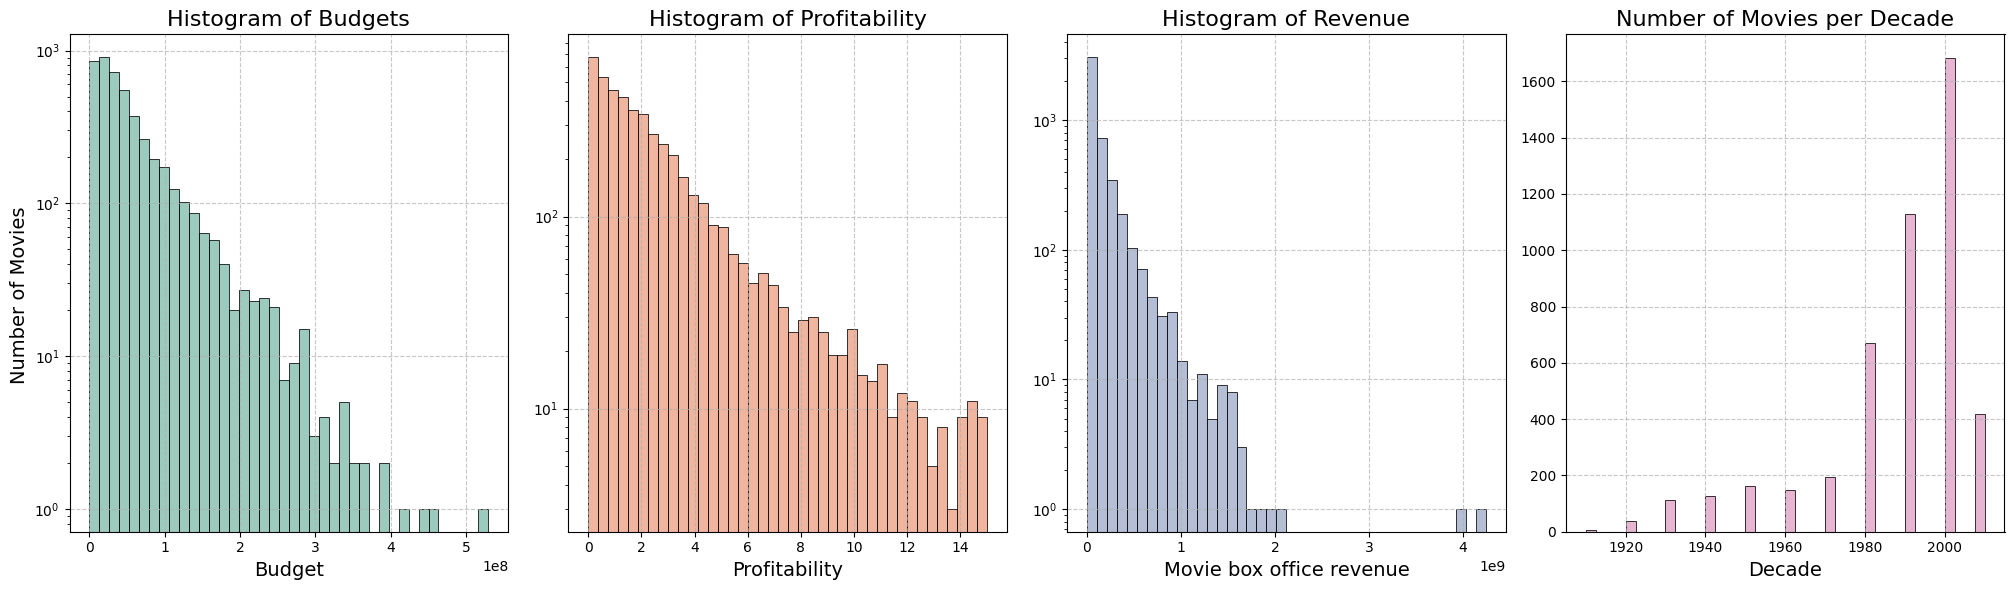

In [9]:
#plot histogram of budgets, profitability and revenue

fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharey=False)

# Defining variables, titles, and colors
variables = ['budget', 'profitability', 'Movie box office revenue', 'decade']
titles = ["Histogram of Budgets", "Histogram of Profitability", "Histogram of Revenue", "Number of Movies per Decade"]
colors = ['#72b6a1', '#e99675', '#95a3c3', '#db96c0']

# Plotting histograms
for i, (ax, var, title, color) in enumerate(zip(axes, variables, titles, colors)):
    sns.histplot(data=df_filtered, x=var, bins=40, kde=False, color=color, alpha=0.7, ax=ax)
    
    if i < 3:  # Set y-axis to log scale for the first three plots
        ax.set_yscale('log')
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(var.capitalize(), fontsize=14)
    ax.set_ylabel("", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)
    
fig.text(0.0, 0.5, 'Number of Movies', ha='center', va='center', rotation='vertical', fontsize=14)
plt.tight_layout()
plt.show()

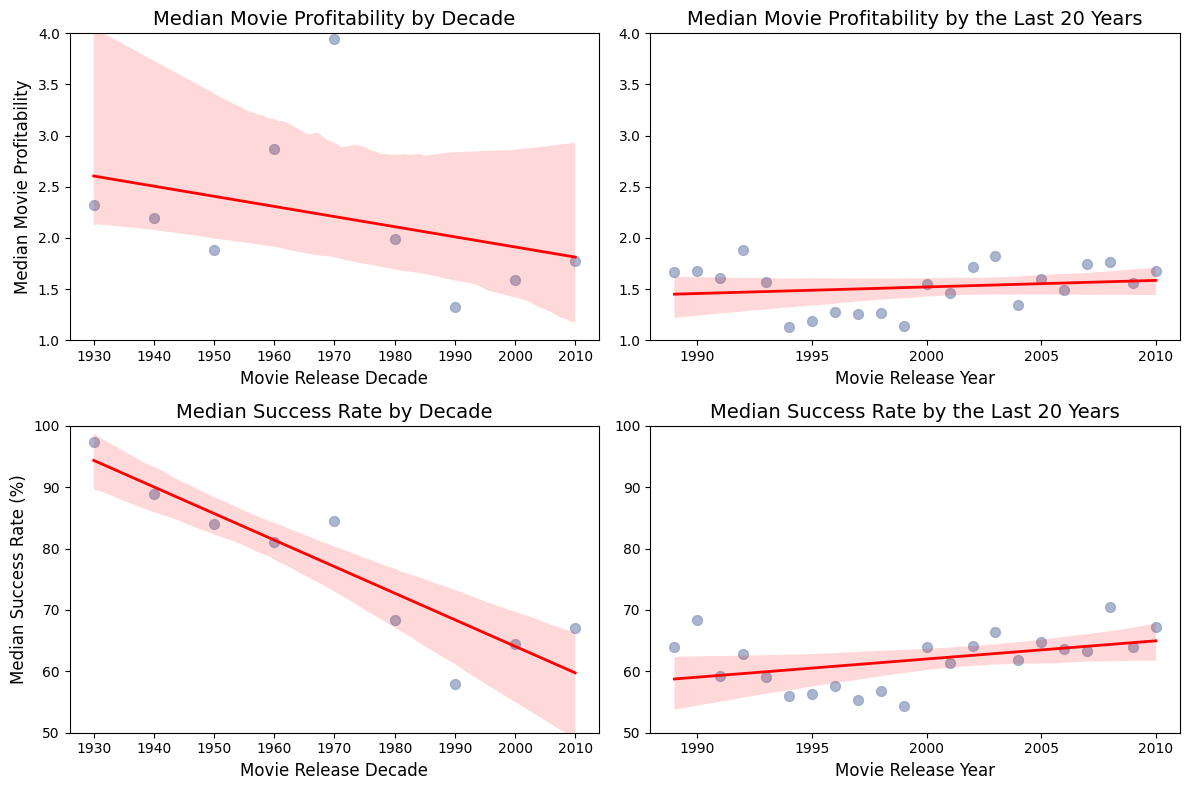

In [10]:
#Add the movie success rate
df_filtered['success rate'] = np.where(df_filtered['profitability'] > 1, 100, 0)

# Filtering profitability data by decade
df_profitability_decade = df_filtered.copy()
df_profitability_decade = df_profitability_decade[df_profitability_decade['profitability'] < 15]
df_profitability_decade = df_profitability_decade[df_profitability_decade['decade'] > 1920]

df_rate_decade = df_filtered.copy()
df_rate_decade = df_rate_decade[df_rate_decade['decade'] > 1920] 

median_rate_by_decade = df_rate_decade.groupby('decade')['success rate'].mean().reset_index()
median_profitability_per_decade = df_profitability_decade.groupby('decade')['profitability'].median().reset_index()

# Filtering profitability data by year
df_profitability_year = df_filtered.copy()
df_profitability_year = df_profitability_year[df_profitability_year['Movie release year'] > 1988]
df_profitability_year = df_profitability_year[df_profitability_year['Movie release year'] < 2011]

df_rate_year = df_filtered.copy()
df_rate_year = df_rate_year[df_rate_year['Movie release year'] > 1988] 
df_rate_year = df_rate_year[df_rate_year['Movie release year'] < 2011] 

median_rate_by_year = df_rate_year.groupby('Movie release year')['success rate'].mean().reset_index()
median_profitability_per_year = df_profitability_year.groupby('Movie release year')['profitability'].median().reset_index()



# Plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=False)

# Plot 1: Median Movie Profitability by Decade
sns.regplot(x=median_profitability_per_decade['decade'], y=median_profitability_per_decade['profitability'], ax=axes[0, 0],
            color='#95a3c3', scatter_kws={'s': 50}, line_kws={'color': 'red', 'linewidth': 2})
axes[0, 0].set_title("Median Movie Profitability by Decade", fontsize=14)
axes[0, 0].set_xlabel("Movie Release Decade", fontsize=12)
axes[0, 0].set_ylabel("Median Movie Profitability", fontsize=12)
axes[0, 0].set_ylim(1, 4)

# Plot 2: Median Movie Profitability by Year
sns.regplot(x=median_profitability_per_year['Movie release year'], y=median_profitability_per_year['profitability'], ax=axes[0, 1],
            color='#95a3c3', scatter_kws={'s': 50}, line_kws={'color': 'red', 'linewidth': 2})
axes[0, 1].set_title("Median Movie Profitability by the Last 20 Years", fontsize=14)
axes[0, 1].set_xlabel("Movie Release Year", fontsize=12)
axes[0, 1].set_ylabel("")
axes[0, 1].set_ylim(1, 4)

# Plot 3: Median Success Rate by Decade
sns.regplot(x=median_rate_by_decade['decade'], y=median_rate_by_decade['success rate'], ax=axes[1, 0],
            color='#95a3c3', scatter_kws={'s': 50}, line_kws={'color': 'red', 'linewidth': 2})
axes[1, 0].set_title("Median Success Rate by Decade", fontsize=14)
axes[1, 0].set_xlabel("Movie Release Decade", fontsize=12)
axes[1, 0].set_ylabel("Median Success Rate (%)", fontsize=12)
axes[1, 0].set_ylim(50, 100)

# Plot 4: Median Success Rate by Year
sns.regplot(x=median_rate_by_year['Movie release year'], y=median_rate_by_year['success rate'], ax=axes[1, 1],
            color='#95a3c3', scatter_kws={'s': 50}, line_kws={'color': 'red', 'linewidth': 2})
axes[1, 1].set_title("Median Success Rate by the Last 20 Years", fontsize=14)
axes[1, 1].set_xlabel("Movie Release Year", fontsize=12)
axes[1, 1].set_ylabel("")
axes[1, 1].set_ylim(50, 100)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

## How did movie release period change with time?

In [11]:
df_1 = df_filtered[df_filtered['decade']>1930]
df_2 = df_filtered[df_filtered['decade']>1988]

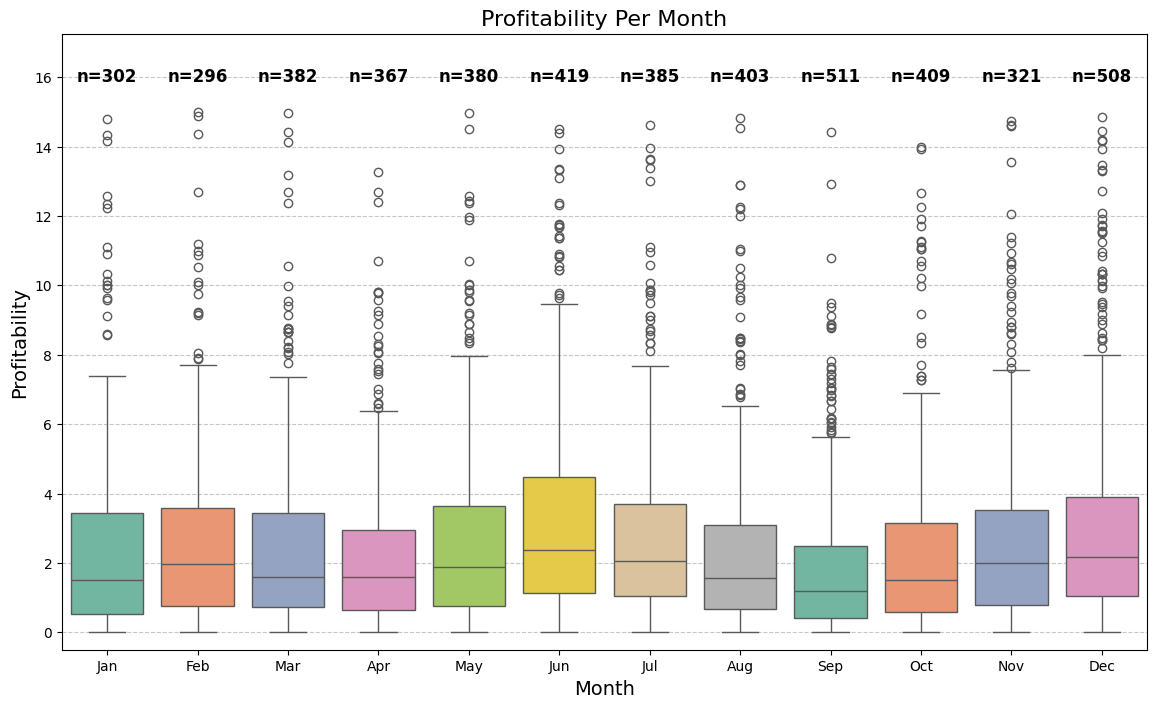

In [12]:
#Boxplot of profitability per month (independent from release year)
plt.figure(figsize=(14, 8))

sns.boxplot(x="Movie release month",y="profitability",data=df_filtered,legend = False,hue = "Movie release month",palette="Set2")

plt.title("Profitability Per Month", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Profitability", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

#Add counts per month
counts = df_filtered['Movie release month'].value_counts().sort_index()
ax = plt.gca()  
y_max = df_filtered['profitability'].max()
y_min = df_filtered['profitability'].min()
y_range = y_max - y_min


for i, decade in enumerate(sorted(counts.index)):
    count = counts[decade]
    ax.text(i, y_max + 0.05 * y_range,  f'n={count}', ha='center', va='bottom',fontsize=12,fontweight='bold')

plt.ylim(y_min-0.5, y_max + 0.15 * y_range)
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(ticks=np.linspace(0,11,12), labels=month_names)

plt.show()

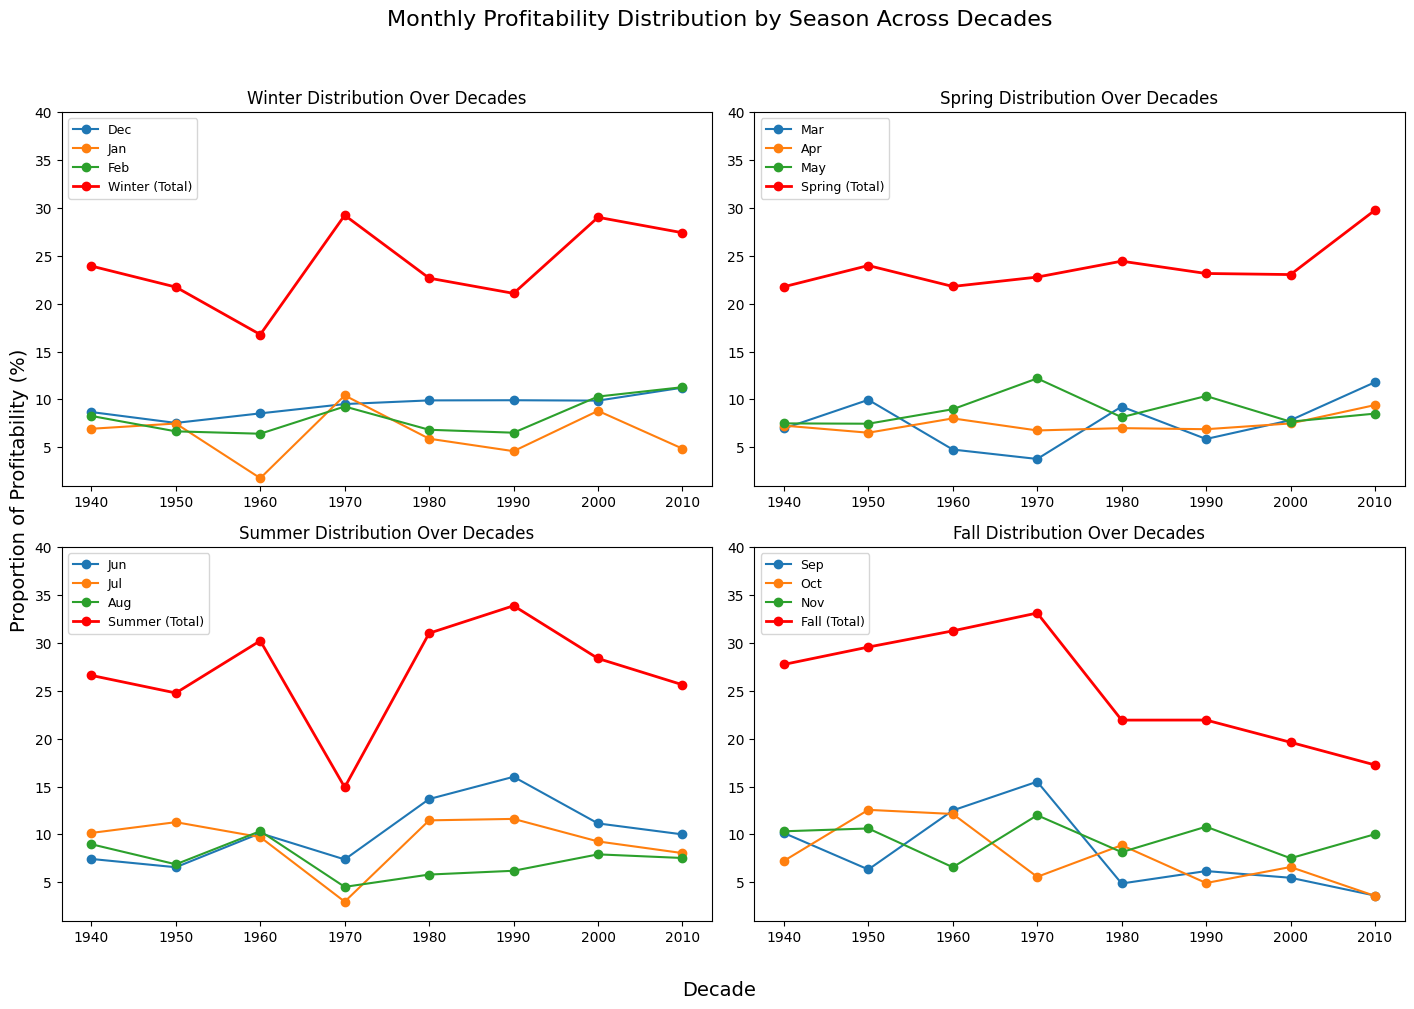

In [13]:
#Line plot showing the proportion of profitability achieved each month for a given decade, grouped by season to observe trends over time.

#prepare data
df_data = df_filtered[df_filtered['decade']>1930]
seasons = {"Winter": [12, 1, 2], "Spring": [3, 4, 5], "Summer": [6, 7, 8], "Fall": [9, 10, 11]}
data = df_data.pivot_table(index="decade", columns="Movie release month", values="profitability", aggfunc="median").fillna(0)

data_proportional = data.div(data.sum(axis=1), axis=0)*100
counts = df_data['decade'].value_counts().sort_index()

month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=False, sharey=False)
axes = axes.flatten()

# Plot each season's monthly profitability with a summed line
for i, (season_name, months) in enumerate(seasons.items()):
    ax = axes[i]

    # Plot individual months
    for month in months:
        ax.plot(
            data_proportional.index,
            data_proportional[month],
            label=month_names[month-1],
            marker="o"
        )
    
    # Calculate and plot the summed line
    season_sum = data_proportional[months].sum(axis=1)
    ax.plot(
        data_proportional.index,
        season_sum,
        label=f"{season_name} (Total)",
        color="red",
        linewidth=2,
        linestyle="-",
        marker="o"
    )

    # Customize axis and labels
    ax.set_title(f"{season_name} Distribution Over Decades", fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(loc="upper left", fontsize=9)
    ax.set_ylim(1, 40)

# Adjust layout and add a title for the entire figure
fig.text(0.0, 0.5, 'Proportion of Profitability (%)', ha='center', va='center', rotation='vertical', fontsize=14)
fig.text(0.5, 0, 'Decade', ha='center', va='center', rotation='horizontal', fontsize=14)

fig.suptitle("Monthly Profitability Distribution by Season Across Decades", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

## Link to our genres

['Movie genres', 'Family Film', 'Romance Film', 'median_budget', '20000000', '40000000', '60000000', '80000000', '100000000', '120000000']


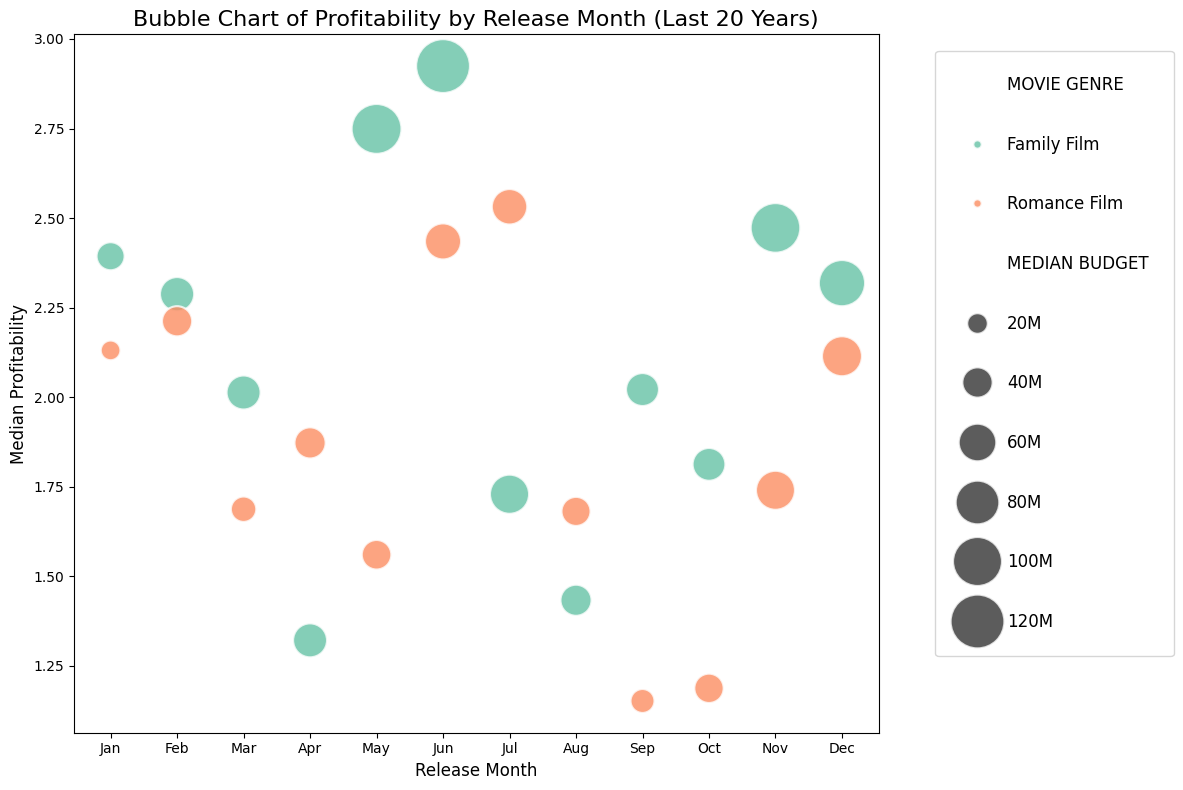

In [14]:
# Bubble chart linking month to profitability for each genre along with the movies budget.
df_bubble = df_exploded.copy()  
df_bubble = df_bubble[df_bubble['decade'] > 1989]  # Keeping only last 20 years
df_bubble = df_bubble[df_bubble['Movie genres'].isin(genres_list)].reset_index(drop=True)

df_aggregated = df_bubble.groupby(['Movie genres', 'Movie release month']).agg(median_profitability=('profitability', 'median'),median_budget=('budget', 'median')).reset_index()

#PLOT
plt.figure(figsize=(12, 8))
bubble_chart = sns.scatterplot(data=df_aggregated,y="median_profitability", x="Movie release month", size="median_budget",  sizes=(200, 1500),  hue="Movie genres",  palette="Set2", alpha=0.8 )

bubble_chart.set_title("Bubble Chart of Profitability by Release Month (Last 20 Years)", fontsize=16)
bubble_chart.set_xlabel("Release Month", fontsize=12)
bubble_chart.set_ylabel("Median Profitability", fontsize=12)

#Customize legend
handles, labels = plt.gca().get_legend_handles_labels()
print(labels)
new_labels = [
    "MOVIE GENRE", 
    "Family Film",
    "Romance Film",
    "MEDIAN BUDGET",  
    "20M",  
    "40M",  
    "60M",  
    "80M",  
    "100M",
    "120M"
]


plt.legend(handles, new_labels, bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=12, borderpad=1.5,labelspacing=2.5, frameon=True, borderaxespad=1)
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(ticks=np.linspace(1,12,12), labels=month_names)
plt.tight_layout()
plt.show()

['Movie genres', 'Family Film', 'Romance Film', 'median_runtime', '95', '100', '105', '110', '115']


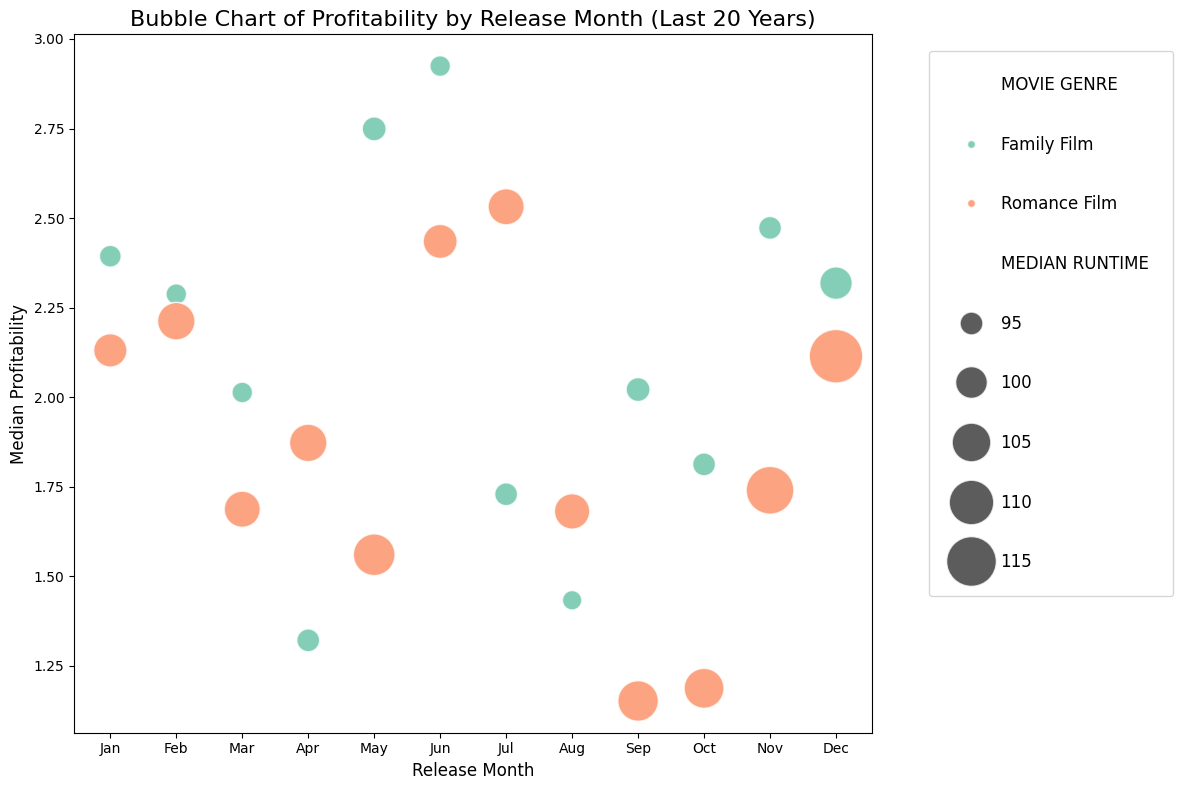

In [15]:
# Bubble chart linking month to profitability for each genre along with the movies budget.
df_bubble = df_exploded.copy()  
df_bubble = df_bubble[df_bubble['decade'] > 1989]  # Keeping only last 20 years
df_bubble = df_bubble[df_bubble['Movie genres'].isin(genres_list)].reset_index(drop=True)

df_aggregated = df_bubble.groupby(['Movie genres', 'Movie release month']).agg(median_profitability=('profitability', 'median'),median_runtime=('Movie runtime', 'median')).reset_index()

#PLOT
plt.figure(figsize=(12, 8))
bubble_chart = sns.scatterplot(data=df_aggregated,y="median_profitability", x="Movie release month", size="median_runtime",  sizes=(200, 1500),  hue="Movie genres",  palette="Set2", alpha=0.8 )

bubble_chart.set_title("Bubble Chart of Profitability by Release Month (Last 20 Years)", fontsize=16)
bubble_chart.set_xlabel("Release Month", fontsize=12)
bubble_chart.set_ylabel("Median Profitability", fontsize=12)

#Customize legend
handles, labels = plt.gca().get_legend_handles_labels()
print(labels)
new_labels = [
    "MOVIE GENRE",
    "Family Film",
    "Romance Film",
    "MEDIAN RUNTIME", 
    "95", 
    "100",
    "105", 
    "110",
    "115",
]

plt.legend(handles, new_labels, bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=12, borderpad=1.5,labelspacing=2.5, frameon=True, borderaxespad=1)
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(ticks=np.linspace(1,12,12), labels=month_names)
plt.tight_layout()
plt.show()

In [16]:
import plotly.express as px
import pandas as pd

# Preparing the data
df_bubble = df_exploded.copy()
df_bubble = df_bubble[df_bubble['decade'] > 1989]  # Filter for the last 20 years
df_bubble = df_bubble[df_bubble['Movie genres'].isin(genres_list)].reset_index(drop=True)

df_aggregated = df_bubble.groupby(['Movie genres', 'Movie release month']).agg(
    median_profitability=('profitability', 'median'),
    median_budget=('budget', 'median')
).reset_index()

# Create the interactive bubble chart
fig = px.scatter(
    df_aggregated,
    x="Movie release month",
    y="median_profitability",
    size="median_budget",
    color="Movie genres",
    hover_name="Movie genres",  # Shows genre name when hovered
    hover_data={
        "median_budget": ":$,.0f",  # Format budget as currency
        "median_profitability": ":.2f",  # Two decimal places for profitability
        "Movie release month": True  # Display the release month
    },
    size_max=60,  # Set maximum bubble size
    labels={"median_profitability": "Median Profitability", "median_budget": "Median Budget ($)", "Movie release month": "Release Month"},
    title="Interactive Bubble Chart of Profitability by Release Month (Last 20 Years)",
)

# Customize x-axis with month names
month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
fig.update_xaxes(
    tickvals=list(range(1, 13)),  # Tick positions
    ticktext=month_names  # Replace numeric ticks with month names
)

# Adjust layout
fig.update_layout(
    title_font_size=18,
    xaxis_title="Release Month",
    yaxis_title="Median Profitability",
    legend_title="Movie Genres",
    legend=dict(
        x=1.05,
        y=1,
        bordercolor="black",
        borderwidth=1,
    ),
)

# Show the interactive plot
fig.show()

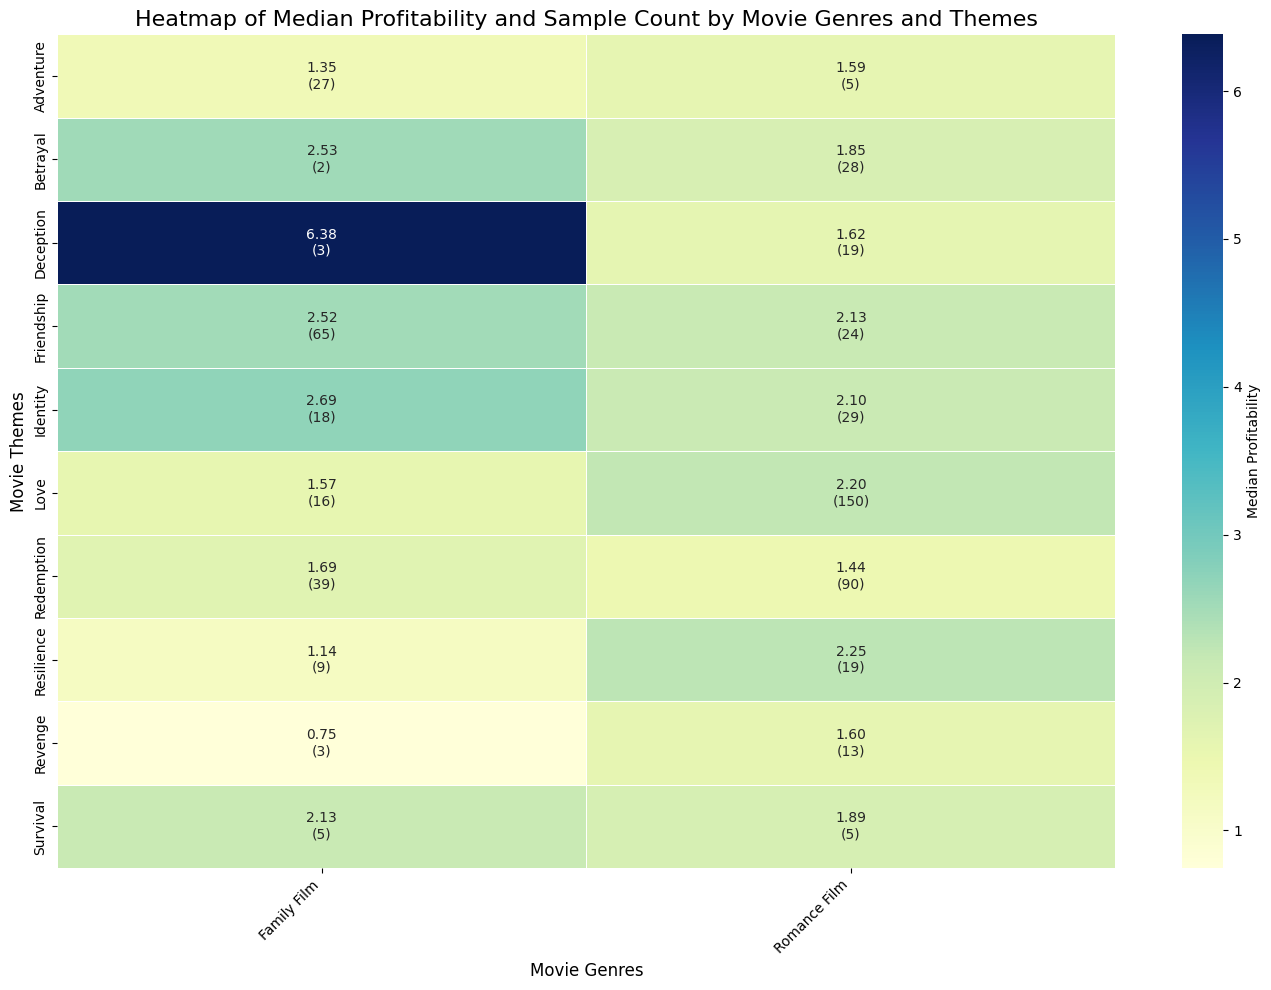

In [17]:
#Heatmap linking themes to genres, for profitability (including sample count between parenthesis)

#Prepare data
df_heatmap = df_exploded.copy()  # Use your filtered dataset
df_heatmap = df_heatmap[df_heatmap['decade'] > 1989]  # Filter by decade
df_heatmap = df_heatmap[df_heatmap['Movie genres'].isin(genres_list)].reset_index(drop=True)
df_heatmap = df_heatmap[df_heatmap['Theme'].isin(top_10_themes.index)].reset_index(drop=True)


#Combine median profitability and sample count into a str
df_aggregated = df_heatmap.groupby(['Movie genres', 'Theme']).agg(
    median_profitability=('profitability', 'median'),
    sample_size=('profitability', 'size')  
).reset_index()

df_heatmap_median = df_aggregated.pivot(index="Theme", columns="Movie genres", values="median_profitability")
df_heatmap_count = df_aggregated.pivot(index="Theme", columns="Movie genres", values="sample_size")

annotations = pd.DataFrame("", index=df_heatmap_median.index, columns=df_heatmap_median.columns, dtype=object)
for row in annotations.index:
    for col in annotations.columns:
        median = df_heatmap_median.loc[row, col]
        count = df_heatmap_count.loc[row, col]
        if not pd.isna(median) and not pd.isna(count):
            annotations.loc[row, col] = f"{median:.2f}\n({int(count)})"

#Plot 
plt.figure(figsize=(14, 10))
sns.heatmap(df_heatmap_median, annot=annotations,  fmt="", cmap="YlGnBu",linewidths=0.5,cbar_kws={'label': 'Median Profitability'})

plt.title("Heatmap of Median Profitability and Sample Count by Movie Genres and Themes", fontsize=16)
plt.xlabel("Movie Genres", fontsize=12)
plt.ylabel("Movie Themes", fontsize=12)

plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()